Subset NC

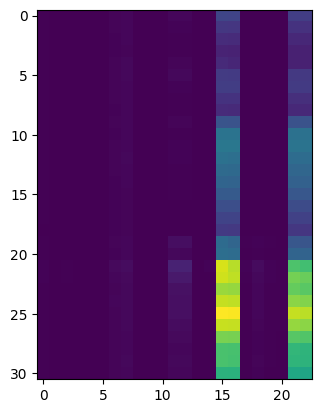

In [5]:
import netCDF4
import numpy as np
from osgeo import gdal,osr,ogr
import matplotlib.pyplot as plt
 
# function to create the mask of your shapefile
# function to create the mask of your shapefile
def makeMask(lon,lat,res):
    source_ds = ogr.Open(shapefile)
    source_layer = source_ds.GetLayer()
 
    # Create high res raster in memory
    mem_ds = gdal.GetDriverByName('MEM').Create('', lon.size, lat.size, gdal.GDT_Byte)
    mem_ds.SetGeoTransform((lon.min(), res, 0, lat.max(), 0, -res))
    band = mem_ds.GetRasterBand(1)
 
    # Rasterize shapefile to grid
    gdal.RasterizeLayer(mem_ds, [1], source_layer, burn_values=[1])
 
    # Get rasterized shapefile as numpy array
    array = band.ReadAsArray()
 
    # Flush memory file
    mem_ds = None
    band = None
    return array
 
# set the data directories
datadir = "/home/mohamed/Documents/DIRECTED/Directed/cs_apps/data/efas_data/"
shapefile = "/home/mohamed/Documents/DIRECTED/data/rheine-erft.shp"
infile = "efas_historical_Rhine_Erft_2023_12.nc"
ncs = datadir + infile
 
# read the netcdf data file
nc = netCDF4.Dataset(ncs,'r')
 
# get the precipitation
pr = nc.variables['dis06'][:]
# Select a specific time step (replace 0 with the desired index)
pr_timestep = pr[:, :, 0]

# Show the precipitation for the selected time step
plt.imshow(pr_timestep)
plt.show()


In [10]:
def makeMask(lon, lat, res, pr_shape):
    source_ds = ogr.Open(shapefile)
    source_layer = source_ds.GetLayer()

    # Create high-res raster in memory
    mem_ds = gdal.GetDriverByName('MEM').Create('', pr_shape[1], pr_shape[0], gdal.GDT_Byte)
    mem_ds.SetGeoTransform((lon.min(), res, 0, lat.max(), 0, -res))
    band = mem_ds.GetRasterBand(1)

    # Rasterize shapefile to grid
    gdal.RasterizeLayer(mem_ds, [1], source_layer, burn_values=[1])

    # Get rasterized shapefile as a numpy array
    array = band.ReadAsArray()

    # Adjust the shape to match the precipitation array shape
    array = np.flipud(array)

    # Flush memory file
    mem_ds = None
    band = None
    return array

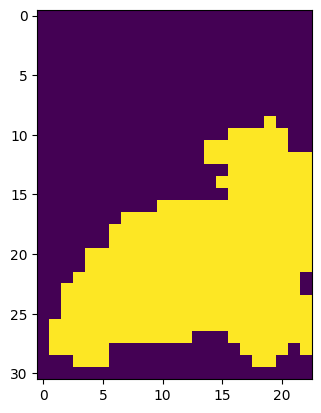

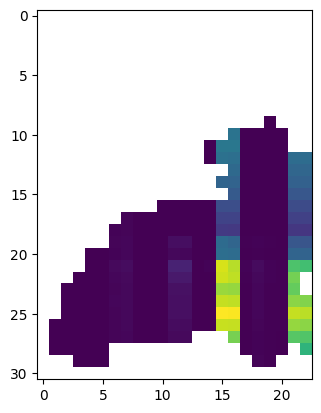

0.0019531595 3.8602926917109928 31.700684


In [13]:
import numpy as np
# get the longitude information
lons = nc.variables['longitude'][:]
# get the latitude information
lats = nc.variables['latitude'][:]
# calculate the cellsize
cellsize = lons[:][1] - lons[:][0]
 
# create the mask
#mask = makeMask(lons,lats,cellsize)
# create the mask
mask = makeMask(lons, lats, cellsize, pr_timestep.shape)

# show the mask
plt.imshow(mask)
plt.show()
 
# mask the precipitation data
precip = np.ma.masked_where(mask==0,pr_timestep)
 
plt.imshow(precip)
plt.show()
 
# print some stats
print (np.min(precip), np.mean(precip), np.max(precip))

In [10]:
#import rasterio as rio
from shapely.geometry import Point
import rioxarray as rio
import geopandas as gpd
import xarray as xr
import os 

In [8]:
shape = '/home/mohamed/Documents/DIRECTED/Directed/cs_apps/data/RWLs/germany_rhein_erft/rhein_erft.geojson'
path = '/home/mohamed/Documents/DIRECTED/Directed/cs_apps/data/efas_data/efas_historical_Rhine_Erft_2023_12.nc'
romagna = rio.open_rasterio(path)
gdf = gpd.read_file(shape)
romagna = romagna.rio.write_crs('EPSG:4258')
gdf1 = gdf.to_crs('epsg:4258')
clipped = romagna.rio.clip(gdf1.geometry.values, gdf1.crs, drop=False, invert=False)
clipped = clipped.to_netcdf("/home/mohamed/Documents/DIRECTED/Directed/cs_apps/data/subset_efas/clipped_rhine_erft_2023_12.nc")

Subset (save to local)

In [6]:
##FINAL WORKING clip and set crs for each RWL
basedir = '/home/mohamed/Documents/DIRECTED/Directed/cs_apps/data/efas_data/'
#shape = '/home/julia/directed/directed_app/data/zürs/germany.json'
shape = '/home/mohamed/Documents/DIRECTED/Directed/cs_apps/data/RWLs/germany_rhein_erft/rhein_erft.geojson'
paths = os.listdir(basedir)
gdf = gpd.read_file(shape)
gdf = gdf.to_crs('epsg:4258')
rwl_merge = [xr.open_dataset(basedir + p) for p in paths if "Rhine_Erft_2010" in p]
merged = xr.merge(rwl_merge)
merged = merged.rio.write_crs('EPSG:4258')
clipped = merged.rio.clip(gdf.geometry.values, gdf.crs, drop=False, invert=False)
clipped = clipped.to_netcdf("/home/mohamed/Documents/DIRECTED/Directed/cs_apps/data/subset_efas//efas_historical_Rhine_Erft_2010.nc")

In [11]:
## WORKING LATLON AND DISCHARGE VALUES through time for single year
basedir = '/home/mohamed/Documents/DIRECTED/Directed/cs_apps/data/efas_data/'
shape = '/home/mohamed/Documents/DIRECTED/Directed/cs_apps/data/RWLs/germany_rhein_erft/rhein_erft.geojson'


paths = os.listdir(basedir)
gdf = gpd.read_file(shape)
gdf = gdf.to_crs('epsg:4258')

rwl_merge = [xr.open_dataset(basedir + p) for p in paths if "Rhine_Erft_2011" in p]
merged = xr.merge(rwl_merge)
merged = merged.rio.write_crs('EPSG:4258')
ds = merged.rio.clip(gdf.geometry.values, gdf.crs, drop=False, invert=False)

latitude = ds['latitude'].values
longitude= ds['longitude'].values
discharge = ds['dis06']
df = discharge.stack(latlon=('latitude', 'longitude')) ##stack latlons into unique pairings by time
df = df.to_dataframe()
df['time'] = df.index.get_level_values('time') #add a time column for each latlon, with discharge
df = df[['time', 'latitude', 'longitude', 'dis06']] #add all columns to the dataframe
df = df.reset_index(drop=True) #reset the index so it is not multi-index
coords_sort = df.sort_values(by=['latitude', 'longitude']) #sort by latlons, ALL data and timestamps


###to export as a geojson
geometry = [Point(xy) for xy in zip(coords_sort['longitude'], coords_sort['latitude'])]
gdf = gpd.GeoDataFrame(coords_sort, geometry=geometry)
gdf.to_file('/home/mohamed/Documents/DIRECTED/Directed/cs_apps/data/geoj_data/rhine_2011_latlon.geojson', driver='GeoJSON')

### export as csv
csv_filename = '/home/mohamed/Documents/DIRECTED/Directed/cs_apps/data/rhine_2011_latlon.csv'
coords_sort.to_csv(csv_filename, index=False)

Multiple years (GeoJSON - Rhein_erft Region)

In [16]:
import os
import geopandas as gpd
import xarray as xr
from shapely.geometry import Point

basedir = '/home/mohamed/Documents/DIRECTED/Directed/cs_apps/data/efas_data/'
shape = '/home/mohamed/Documents/DIRECTED/Directed/cs_apps/data/RWLs/germany_rhein_erft/rhein_erft.geojson'

gdf = gpd.read_file(shape)
gdf = gdf.to_crs('epsg:4258')

years = range(2010, 2024)

for year in years:
    # Update the file pattern for the new naming convention
    file_pattern = f"efas_historical_Rhine_Erft_{year}"
    
    # Filter files based on the year
    paths = [p for p in os.listdir(basedir) if file_pattern in p]
    
    if paths:
        rwl_merge = [xr.open_dataset(os.path.join(basedir, p)) for p in paths]
        merged = xr.merge(rwl_merge)
        merged = merged.rio.write_crs('EPSG:4258')
        ds = merged.rio.clip(gdf.geometry.values, gdf.crs, drop=False, invert=False)

        latitude = ds['latitude'].values
        longitude = ds['longitude'].values
        discharge = ds['dis06']
        df = discharge.stack(latlon=('latitude', 'longitude'))
        df = df.to_dataframe()
        df['time'] = df.index.get_level_values('time')
        df = df[['time', 'latitude', 'longitude', 'dis06']]
        df = df.reset_index(drop=True)
        coords_sort = df.sort_values(by=['latitude', 'longitude'])

        ### Export as GeoJSON
        geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
        gdf_temp = gpd.GeoDataFrame(df, geometry=geometry)
        output_geojson = f'/home/mohamed/Documents/DIRECTED/Directed/cs_apps/data/geoj_data/rhine_{year}_latlon.geojson'
        gdf_temp.to_file(output_geojson, driver='GeoJSON')
        print(f"GeoJSON file for {year} saved")

        ### Export as CSV
        # output_csv = f'/home/mohamed/Documents/DIRECTED/Directed/cs_apps/data/rhine_{year}_latlon.csv'
        # df.to_csv(output_csv, index=False)
        # print(f"CSV file for {year}")
    else:
        print(f"No data found for {year}")


GeoJSON file for 2010 saved
GeoJSON file for 2011 saved
GeoJSON file for 2012 saved
GeoJSON file for 2013 saved
GeoJSON file for 2014 saved
GeoJSON file for 2015 saved
GeoJSON file for 2016 saved
GeoJSON file for 2017 saved
GeoJSON file for 2018 saved
GeoJSON file for 2019 saved
GeoJSON file for 2020 saved
GeoJSON file for 2021 saved
GeoJSON file for 2022 saved
GeoJSON file for 2023 saved
